In [333]:
''' RNN Bidireccional en Keras '''
__author_ = '@Tssp'
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Dropout, LSTM, Bidirectional
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
import pandas as pd  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats.stats import pearsonr
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.dates as mdates
from utils.NNutils import *
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
plt.rcParams['axes.labelsize']=16
plt.rcParams['axes.titlesize']=16

In [334]:
# Radon
mdnRnA = np.loadtxt('../../mdnRnA.txt', delimiter=',')
newValuesReal = np.loadtxt('../../mdnRnA_validation.txt', delimiter=',')
startday = pd.datetime(2013, 7, 1)
dates = pd.date_range(startday, periods=len(mdnRnA), freq='W')
dates[-1]

Timestamp('2019-07-21 00:00:00', freq='W-SUN')

In [335]:
# Weather
NVR = pd.read_csv('../Data/Daily/NVR/NVR_arima_weekly.csv', usecols=['fecha', 'tmed', 'presmed', 'velmedia'])
NVR['fecha'] = pd.to_datetime(NVR['fecha'])
NVR.describe()

,tmed,velmedia,presmed
count,316.000000,316.000000,316.000000
mean,13.614248,3.577390,965.829927
std,6.472158,1.177355,5.245625
min,1.271429,0.528571,947.739409
25%,7.857143,2.782143,963.025000
50%,13.657143,3.542857,965.839286
75%,18.934184,4.378571,968.598214
max,26.957143,6.585714,980.928571


In [336]:
DF = pd.DataFrame({'dates': dates,'mdnRnA': mdnRnA, 'T': NVR['tmed'].values[:len(mdnRnA)]})
DF.head()

,T,dates,mdnRnA
0,21.800000,2013-07-07,90.0
1,25.271429,2013-07-14,79.0
2,24.614286,2013-07-21,99.0
3,25.842857,2013-07-28,117.0
4,25.314286,2013-08-04,99.0


In [337]:
def scaleDF(DF):
    scalermdnRnA = MinMaxScaler(feature_range=(-1, 1))
    scalerT = MinMaxScaler(feature_range=(-1, 1))
    outputDF = pd.DataFrame()
    mdnRnAscaled = DF['mdnRnA'].values.reshape(-1, 1)
    Tscaled = DF['T'].values.reshape(-1, 1)
    outputDF['mdnRnA'] = scalermdnRnA.fit_transform(mdnRnAscaled).reshape(-1)
    outputDF['T'] = scalerT.fit_transform(Tscaled).reshape(-1)
    outputDF['dates'] = DF['dates']
    return outputDF, scalermdnRnA
# Inverse Scalling
# predmins = scaler.inverse_transform(np.array(predmins).reshape(-1, 1))

In [338]:
DF_scaled, scalermdnRnA = scaleDF(DF)
DF_scaled.head()

,mdnRnA,T,dates
0,0.146667,0.598443,2013-07-07
1,-0.146667,0.868743,2013-07-14
2,0.386667,0.817575,2013-07-21
3,0.866667,0.913237,2013-07-28
4,0.386667,0.872080,2013-08-04


In [339]:
sample_size = 52
# dataframe (empty) creation
pdata = pd.DataFrame()
pdatamdnRnA = pd.DataFrame()
names=list()
#print('pdata_raw 0',pdata_raw)
print('pdata 0',pdata)

pdata 0 Empty DataFrame
Columns: []
Index: []


In [340]:
nlags= len(newValuesReal)-1
for i in range(nlags, -1, -1):
    # Add the new lagged column at the end of the dataframe. In inverse order.
    pdata = pd.concat([pdata, DF_scaled[['T', 'mdnRnA']].shift(i).reset_index(drop=True)], axis=1)
    pdatamdnRnA = pd.concat([pdatamdnRnA, DF_scaled['mdnRnA'].shift(i).reset_index(drop=True)], axis=1)
    names += str(i) # store this index for naming the columns of dataframe

In [341]:
pdata.head()

,T,mdnRnA,T,mdnRnA,T,mdnRnA,T,mdnRnA,T,mdnRnA,T,mdnRnA,T,mdnRnA,T,mdnRnA,T,mdnRnA
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598443,0.146667
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598443,0.146667,0.868743,-0.146667
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598443,0.146667,0.868743,-0.146667,0.817575,0.386667
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598443,0.146667,0.868743,-0.146667,0.817575,0.386667,0.913237,0.866667
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598443,0.146667,0.868743,-0.146667,0.817575,0.386667,0.913237,0.866667,0.872080,0.386667


In [342]:
pdatalags = np.asarray(pdata[nlags:])
pdatamdnRnAlags = np.asarray(pdatamdnRnA[nlags:])
pdatalags.shape

(308, 18)

In [343]:
X = np.array([pdatalags[start:start+sample_size] for start in range(0, pdatalags.shape[0]-sample_size)])
Y = pdatamdnRnAlags[sample_size:]
Y.shape

(256, 9)

In [344]:
test_size = int(0.3*len(mdnRnA))
X_train, X_test = X[:-test_size], X[-test_size:]
Y_train, Y_test = Y[:-test_size], Y[-test_size:]
print("X_train.shape = ", X_train.shape, "\nY_train.shape = ", Y_train.shape)

X_train.shape =  (162, 52, 18) 
Y_train.shape =  (162, 9)


In [345]:
def LSTM_v2(neurons, nep, X_train, Y_train, X_test, Y_test, sample_size, v=2, btch_size=10, save=False):
    model = Sequential()
    model.add( Bidirectional( LSTM(neurons[0], activation='tanh', return_sequences=True), 
                             input_shape=X_train.shape[1:] ) )
    model.add(Flatten())
    model.add(Dense(int(neurons[1]/2), activation='linear'))
    model.add(Dense(Y_train.shape[1], activation='linear'))
    model.compile(loss="mae", optimizer="adam", metrics=["acc"])
    history = model.fit(X_train, Y_train, epochs=nep, batch_size=btch_size, verbose=v, validation_data=(X_test, Y_test))
    pred = model.predict(X_test)
    acc_train = np.average(history.history["acc"])
    acc_test = np.average(history.history["val_acc"])
    if save:
        save_NN(model)
    return history, pred, acc_train, acc_test, model

In [346]:
neuron = [52, 208]
history, pred, acc_train, acc_test, model = LSTM_v2(neuron, 6, X_train, Y_train, X_test, Y_test, sample_size)

Train on 162 samples, validate on 94 samples
Epoch 1/6
 - 8s - loss: 0.4688 - acc: 0.1667 - val_loss: 0.3096 - val_acc: 0.1915
Epoch 2/6
 - 3s - loss: 0.2828 - acc: 0.1728 - val_loss: 0.2253 - val_acc: 0.2128
Epoch 3/6
 - 3s - loss: 0.2116 - acc: 0.2222 - val_loss: 0.1723 - val_acc: 0.2340
Epoch 4/6
 - 3s - loss: 0.1685 - acc: 0.3025 - val_loss: 0.1734 - val_acc: 0.3404
Epoch 5/6
 - 3s - loss: 0.1559 - acc: 0.3765 - val_loss: 0.1597 - val_acc: 0.3191
Epoch 6/6
 - 3s - loss: 0.1428 - acc: 0.4383 - val_loss: 0.1482 - val_acc: 0.4149


In [316]:
predmaxs, predmins, predavgs = extract_maxs_mins_avgs(pred)
# Inverse scaler
predmins = scalermdnRnA.inverse_transform(np.array(predmins).reshape(-1, 1))[:,0]
predmaxs = scalermdnRnA.inverse_transform(np.array(predmaxs).reshape(-1, 1))[:,0]
predavgs = scalermdnRnA.inverse_transform(np.array(predavgs).reshape(-1, 1))[:,0]

ECM: 36.1596
EAM: 4.5009
0.14268094158553063


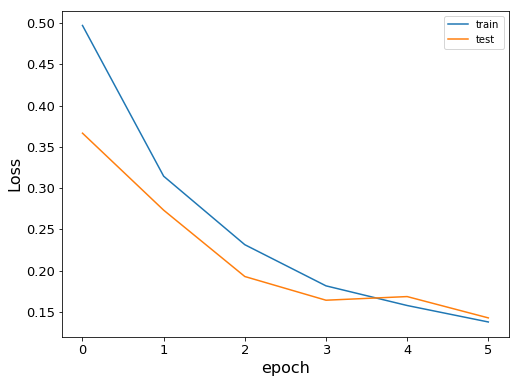

In [317]:
#Y_test_error = mdnRnA[-len(predavgs):]
Y_test_error = DF['mdnRnA'][-len(predavgs):]
testScoreECM = mean_squared_error(Y_test_error, predavgs)
print('ECM: %.4f' % (testScoreECM))
testScoreEAM = mean_absolute_error(Y_test_error, predavgs)
print('EAM: %.4f' % (testScoreEAM))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))# 6,6
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
print(np.min(history.history['val_loss']))

In [318]:
startday = pd.datetime(2013, 7, 1)
startdaypred = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA)-len(pred), unit='D') - 7*pd.Timedelta(len(newValuesReal),
                                                                                                           unit='D')
startdayahead = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA), unit='D')

In [319]:
scalerfuture = MinMaxScaler(feature_range=(-1, 1))
futurescaled = np.array(newValuesReal).reshape(-1, 1)
futurescaled = scalerfuture.fit_transform(np.array(newValuesReal).reshape(-1, 1)).reshape(-1)

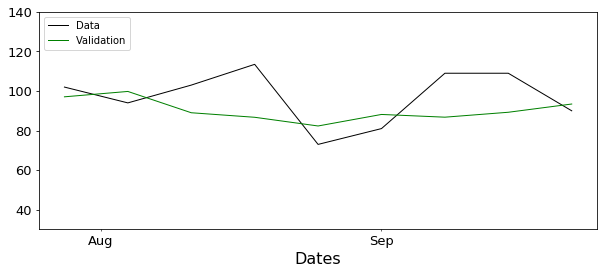

In [320]:
# Pronostico:
Xval = np.atleast_3d(np.array([pdatalags[-sample_size:]]))
predval = model.predict(Xval)[0,:]
predval = scalerfuture.inverse_transform(np.array(predval).reshape(-1, 1))[:,0]
plot_validation(newValuesReal, predval, startdayahead)

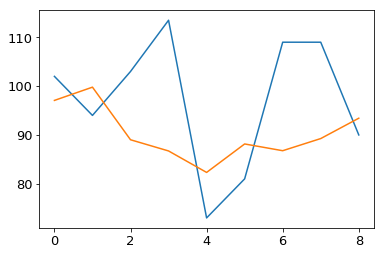

In [321]:
plt.plot(newValuesReal)
plt.plot(predval)

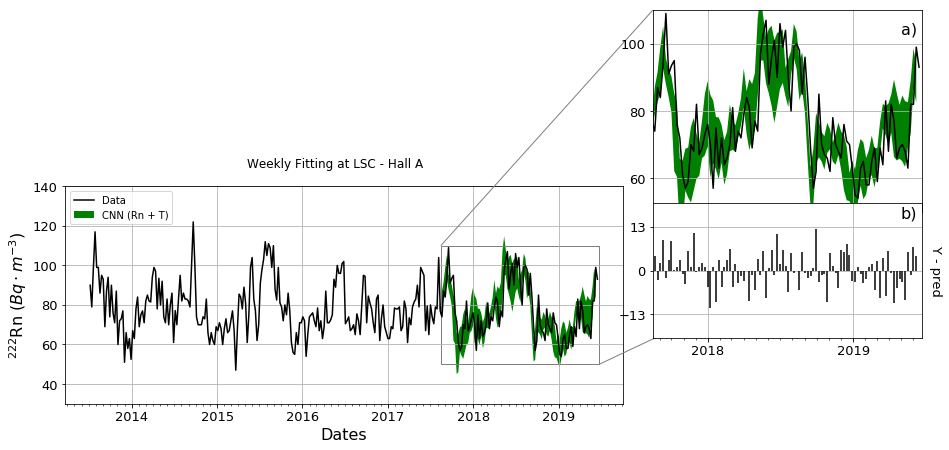

In [322]:
dist = mdnRnA[-len(predavgs):] - predavgs
plot_fill_errors(mdnRnA, predmins, predmaxs, predavgs, dist, startday, startdaypred)

# Only $^{222}Rn$

In [323]:
mdnRnA = np.loadtxt('../../mdnRnA.txt', delimiter=',')
newValuesReal = np.loadtxt('../../mdnRnA_validation.txt', delimiter=',')
nlags= len(newValuesReal)-1
startday = pd.datetime(2013, 7, 1)
dates = pd.date_range(startday, periods=len(mdnRnA), freq='W')
# Weather
NVR = pd.read_csv('../Data/Daily/NVR/NVR_arima_weekly.csv', usecols=['fecha', 'tmed', 'presmed', 'velmedia'])
NVR['fecha'] = pd.to_datetime(NVR['fecha'])
DF = pd.DataFrame({'dates': dates,'mdnRnA': mdnRnA, 'T': NVR['tmed'].values})
DF_scaled, scalermdnRnA = scaleDF(DF)
sample_size = 52
# dataframe (empty) creation
pdata = pd.DataFrame()
pdatamdnRnA = pd.DataFrame()
names=list()
nlags= len(newValuesReal)-1
for i in range(nlags, -1, -1):
    # Add the new lagged column at the end of the dataframe. In inverse order.
    pdata = pd.concat([pdata, DF_scaled[['T', 'mdnRnA']].shift(i).reset_index(drop=True)], axis=1)
    pdatamdnRnA = pd.concat([pdatamdnRnA, DF_scaled['mdnRnA'].shift(i).reset_index(drop=True)], axis=1)
    names += str(i) # store this index for naming the columns of dataframe
pdatalags = np.asarray(pdata[nlags:])
pdatamdnRnAlags = np.asarray(pdatamdnRnA[nlags:])   
X = np.atleast_3d(np.array([pdatamdnRnAlags[start:start + sample_size]
    for start in range(0, pdatamdnRnAlags.shape[0]-sample_size)]))
Y = pdatamdnRnAlags[sample_size:]
test_size = int(0.3*len(mdnRnA))
X_train,X_test = X[:-test_size], X[-test_size:]
Y_train,Y_test = Y[:-test_size], Y[-test_size:]

In [324]:
print("X_train.shape = ", X_train.shape, "\nY_train.shape = ", Y_train.shape)

X_train.shape =  (162, 52, 9) 
Y_train.shape =  (162, 9)


In [325]:
def LSTM_v2(neurons, nep, X_train, Y_train, X_test, Y_test, sample_size, v=2, btch_size=10, save=False):
    model = Sequential()
    model.add( Bidirectional( LSTM(neurons[0], activation='tanh', return_sequences=True), 
                             input_shape=X_train.shape[1:] ) )
    model.add(Flatten())
    model.add(Dense(int(neurons[1]/2), activation='linear'))
    model.add(Dense(Y_train.shape[1], activation='linear'))
    
    model.compile(loss="mae", optimizer="adam", metrics=["acc"])
    history = model.fit(X_train, Y_train, epochs=nep, batch_size=btch_size, verbose=v, validation_data=(X_test, Y_test))
    pred = model.predict(X_test)
    acc_train = np.average(history.history["acc"])
    acc_test = np.average(history.history["val_acc"])
    if save:
        save_NN(model)
    return history, pred, acc_train, acc_test, model

In [326]:
neuron = [52, 32]
history, pred, acc_train, acc_test, model = LSTM_v2(neuron, 4, X_train, Y_train, X_test, Y_test, sample_size)
predmaxs, predmins, predavgs = extract_maxs_mins_avgs(pred)
# Inverse scaler
predmins = scalermdnRnA.inverse_transform(np.array(predmins).reshape(-1, 1))[:,0]
predmaxs = scalermdnRnA.inverse_transform(np.array(predmaxs).reshape(-1, 1))[:,0]
predavgs = scalermdnRnA.inverse_transform(np.array(predavgs).reshape(-1, 1))[:,0]

Train on 162 samples, validate on 94 samples
Epoch 1/4
 - 8s - loss: 0.2900 - acc: 0.1605 - val_loss: 0.2293 - val_acc: 0.1702
Epoch 2/4
 - 3s - loss: 0.2195 - acc: 0.2654 - val_loss: 0.1947 - val_acc: 0.2766
Epoch 3/4
 - 3s - loss: 0.2076 - acc: 0.2654 - val_loss: 0.1850 - val_acc: 0.2660
Epoch 4/4
 - 3s - loss: 0.1751 - acc: 0.3086 - val_loss: 0.1661 - val_acc: 0.2766


ECM: 59.4775
EAM: 5.9027
0.16606049540829151


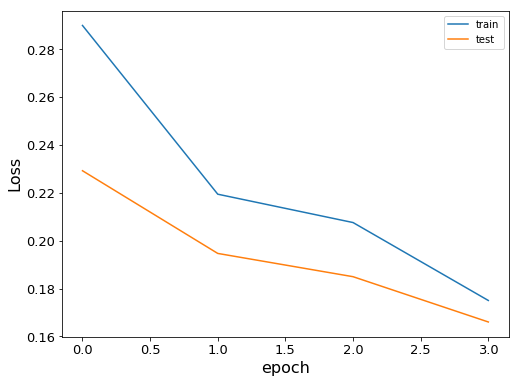

In [327]:
Y_test_error = DF['mdnRnA'][-len(predavgs):]
testScoreECM = mean_squared_error(Y_test_error, predavgs)
print('ECM: %.4f' % (testScoreECM))
testScoreEAM = mean_absolute_error(Y_test_error, predavgs)
print('EAM: %.4f' % (testScoreEAM))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))# 6,6
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
print(np.min(history.history['val_loss']))

In [328]:
# Pronostico:
Xval = np.atleast_3d(np.array([pdatamdnRnAlags[-sample_size:]]))
predval = model.predict(Xval)[0,:]
predval = scalerfuture.inverse_transform(np.array(predval).reshape(-1, 1))[:,0]

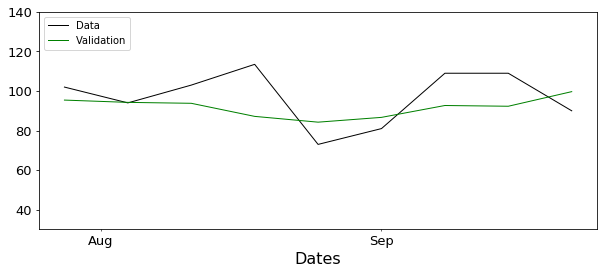

In [329]:
startday = pd.datetime(2013, 7, 1)
startdaypred = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA)-len(pred), unit='D') - 7*pd.Timedelta(len(newValuesReal),
                                                                                                           unit='D')
startdayahead = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA), unit='D')
plot_validation(newValuesReal, predval, startdayahead)

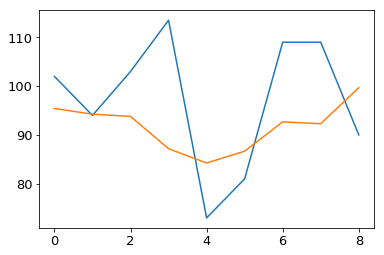

In [330]:
plt.plot(newValuesReal)
plt.plot(predval)

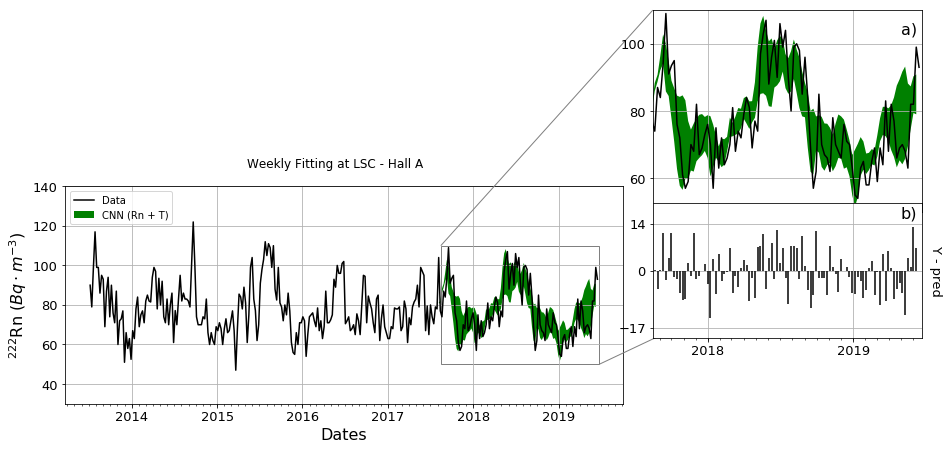

In [331]:
dist = mdnRnA[-len(predavgs):] - predavgs
plot_fill_errors(mdnRnA, predmins, predmaxs, predavgs, dist, startday, startdaypred)

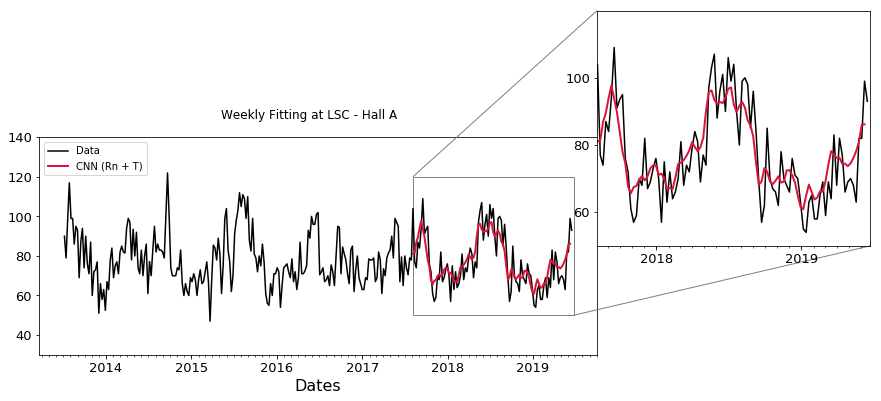

In [332]:
plot_forecast(mdnRnA, startday, predavgs, startdaypred)